In [ ]:
import sys

# New Section

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/COMSCI M146/HW/PS1']
!!ls '/content/drive/My Drive/COMSCI M146/HW/PS1'
### ========== TODO : END ========== ###


[" adult_subsample.csv\t\t    'Problem Set 1 Q 3.ipynb'   Solutions",
 " nutil.py\t\t\t    'Problem Set 1 Q4.ipynb'",
 "'Part i of Problem Set 1 Q4.ipynb'   __pycache__"]

In [ ]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        self.probabilities_ = [0,0]
        self.probabilities_[0] = Counter(y)[0]/(Counter(y)[0]+Counter(y)[1])
        self.probabilities_[1] = Counter(y)[1]/(Counter(y)[0]+Counter(y)[1])
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        prob = [self.probabilities_[0],self.probabilities_[1]]
        n,d = X.shape
        y=np.random.choice(2,(n,),p=prob)

        ### ========== TODO : END ========== ###

        return y


In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    splt = StratifiedShuffleSplit(n_splits = ntrials, test_size = test_size, random_state = 0)
    splt.get_n_splits(X)
    train_error = 0
    test_error = 0
    f1_score = 0
    for i, (train_index, test_index) in enumerate(splt.split(X, y)):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      clf.fit(X_train, y_train)
      y_predtrain = clf.predict(X_train)
      y_predtest = clf.predict(X_test)
      train_error += 1 - metrics.accuracy_score(y_train, y_predtrain)
      test_error += 1 - metrics.accuracy_score(y_test, y_predtest)
      f1_score += metrics.f1_score(y_test, y_predtest, average = 'micro')
    train_error = train_error/ntrials
    test_error = test_error/ntrials
    f1_score = f1_score/ntrials
    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...


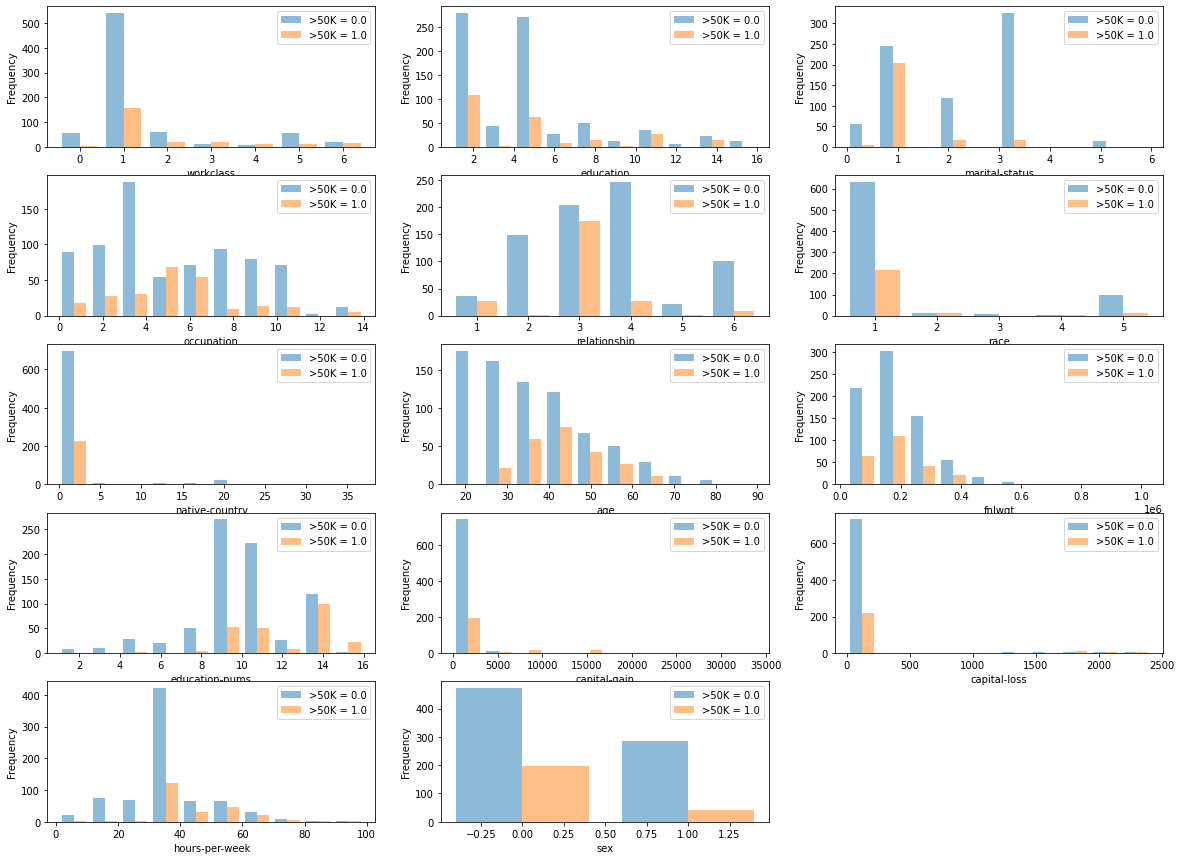

Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using 3 -Nearest Neighbors...
	-- training error: 0.153
Classifying using 5 -Nearest Neighbors...
	-- training error: 0.195
Classifying using 7 -Nearest Neighbors...
	-- training error: 0.213
Investigating various classifiers...
For Majority
(0.2399999999999996, 0.2399999999999996, 0.7600000000000002)
For Random
(0.37477500000000014, 0.38199999999999984, 0.6180000000000002)
For DecisionTree
(0.0, 0.20475, 0.7952500000000002)
For KNN
(0.20167499999999997, 0.25915000000000005, 0.7408499999999998)
Finding the best k...


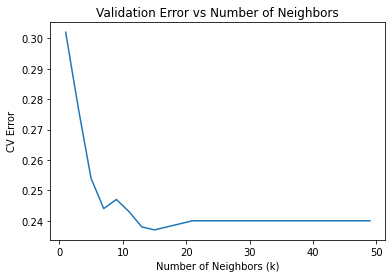

Best k value:  15
Investigating depths...
Investigating depths...


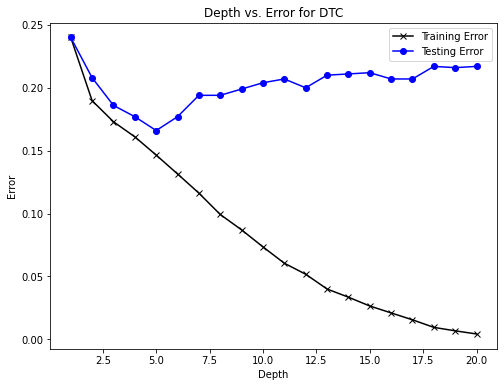

Done


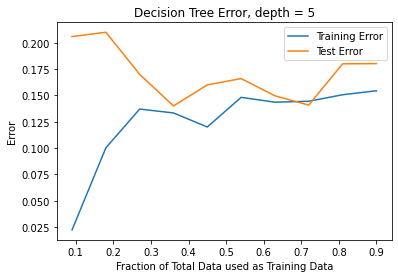

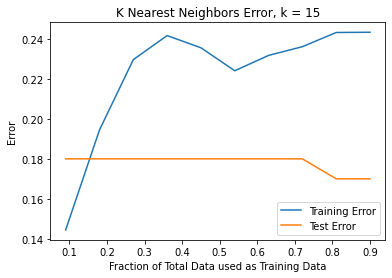

In [ ]:
from sklearn.metrics.cluster import entropy

######################################################################
# main
######################################################################

def main():



    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/COMSCI M146/HW/PS1/adult_subsample.csv"
    ### ========== TODO : END ========== ###


    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features




    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    plt.show()



    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)

    # Initialize the StandardScaler
    #scaler = StandardScaler()

    # Fit the scaler to the data and then transform the data
    #X = scaler.fit_transform(X)
    #print("X standardized")

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    ran_class = RandomClassifier() # create MajorityVote classifier, which includes all model parameters
    ran_class.fit(X, y)                  # fit training data using the classifier
    y_pred = ran_class.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)


    # print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    DT = DecisionTreeClassifier(criterion = 'entropy')
    DT.fit(X,y)
    y_pred = DT.predict(X)
    train_error = 1 -  metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    k = np.array([3,5,7])
    for i in k:
     print('Classifying using', i, '-Nearest Neighbors...')
     KNN = KNeighborsClassifier(n_neighbors = i)
     KNN.fit(X, y)
     y_pred = KNN.predict(X)
     train_error = 1 -  metrics.accuracy_score(y, y_pred, normalize=True)
     # print the error for each k
     print('\t-- training error: %.3f' % train_error)


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')
    clfs = {"Majority":MajorityVoteClassifier(), "Random":RandomClassifier(), "DecisionTree":DecisionTreeClassifier(criterion = 'entropy'), "KNN":KNeighborsClassifier(n_neighbors = 5)}
    for i in clfs:
      print('For', i)
      #print(np.shape(X))
      #print(np.shape(y))
      summary = error(clfs[i], X, y, 100)
      print(summary)
    # summary = error(clf, X, y, ntrials=20)
    # print(summary)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')

    # Odd number of neighbors ranging from 1-50
    k_vals = range(1,50,2)

    # Initialize an empty list that stores the mean accuracy for each k
    cv_scores = []

    # Loop through range of all relevant k values
    # Append each cv score to list and take the mean
    for k in k_vals:
      KNN = KNeighborsClassifier(n_neighbors=k)
      cv_score = cross_val_score(KNN, X, y, cv=10)
      cv_scores.append(cv_score.mean())

    # Convert the list into a list with error values
    error_vals = 1 - np.array(cv_scores)

    # Plot values
    plt.title("Validation Error vs Number of Neighbors")
    plt.plot(k_vals, error_vals)
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('CV Error')
    plt.show()

    # Evaluating the best k value
    k_index = np.argmin(error_vals)
    best_k = k_vals[k_index]
    print("Best k value: ", best_k)

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    print('Investigating depths...')
    depth_list = list(range(1,21))
    total_train = []
    total_test = []
    list_depth = []

    for i in depth_list:
      clf_dtc = DecisionTreeClassifier(criterion='entropy', max_depth = i)

      # cross validate
      cv_results = cross_validate(clf_dtc, X, y, return_train_score = True)
      # print(cv_results['test_score'])
      # print(cv_results['train_score'])
      total_train.append(1 - (sum(cv_results['train_score']) / len(cv_results['train_score'])))
      total_test.append(1 - (sum(cv_results['test_score']) / len(cv_results['test_score'])))
      list_depth.append(i)


    fig = plt.figure(figsize = (8, 6)).add_subplot()
    fig.plot(list_depth, total_train, label = "Training Error", color = "black", marker = "x")
    fig.plot(list_depth, total_test,  label = "Testing Error",  color = "blue",  marker = "o")
    plt.title("Depth vs. Error for DTC")
    plt.xlabel("Depth")
    plt.ylabel("Error")
    plt.legend()
    plt.show()
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)


    #test_size is always 0.1, train_size is will vary from 0.1 to 1.0

    #x_td_amt = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    x_td_amt = [0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.9]
    y_tree_train_error = []
    y_tree_test_error = []

    y_knn_train_error = []
    y_knn_test_error = []

    for i in x_td_amt:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size =i, random_state = 0)
      #print ("X_train: " , X_train)
      #print ("y_train: " , y_train)

      #run tree training
      #run tree evaluation
      #append results in y_tree_train_err = [], y_tree_test_err = []

      #FUCKS HITS
      clfs = {"DecisionTree":DecisionTreeClassifier(criterion = 'entropy', max_depth = 5), "KNN":KNeighborsClassifier(n_neighbors = 15)}
      for j in clfs:
        train_error = 0
        test_error = 0

        ntrials = 100
        for k in range(ntrials):
          clfs[j].fit(X_train, y_train)
          y_predtrain = clfs[j].predict(X_train)
          y_predtest = clfs[j].predict(X_test)
          train_error += 1 - metrics.accuracy_score(y_train, y_predtrain)
          test_error += 1 - metrics.accuracy_score(y_test, y_predtest)

        train_error = train_error/ntrials
        test_error = test_error/ntrials

        if j == "DecisionTree":
          y_tree_train_error.append(train_error)
          y_tree_test_error.append(test_error)
        if j == "KNN":
          y_knn_train_error.append(train_error)
          y_knn_test_error.append(test_error)

    plt.figure()
    plt.plot(x_td_amt, y_tree_train_error, label = 'Training Error')
    plt.plot(x_td_amt, y_tree_test_error, label = 'Test Error')
    plt.legend()
    plt.xlabel('Fraction of Total Data used as Training Data')
    plt.ylabel('Error')
    plt.title('Decision Tree Error, depth = 5')

    plt.figure()
    plt.plot(x_td_amt, y_knn_train_error, label = 'Training Error')
    plt.plot(x_td_amt, y_knn_test_error, label = 'Test Error')
    plt.legend()
    plt.xlabel('Fraction of Total Data used as Training Data')
    plt.ylabel('Error')
    plt.title('K Nearest Neighbors Error, k = 15')
    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
